In [1]:
# from kaggle_secrets import UserSecretsClient
# secret_label = "Token"
# token = UserSecretsClient().get_secret(secret_label)

# ! git clone --branch fra https://{token}@github.com/FrancescoZanella/RecSysChallenge2024.git

In [2]:
# %cd /kaggle/working/RecSysChallenge2024/src

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from polimi.utils._custom import GetMemUsage, PrintColor
from polimi.utils._polars import reduce_polars_df_memory_size
from ebrec.evaluation.metrics_protocols import *
from polimi.utils._catboost import add_trendiness_feature, add_mean_delays_features,add_history_trendiness_scores_feature
from polimi.utils._custom import *

from catboost import CatBoostClassifier

# Data import

In [2]:
from polimi.utils._custom import load_dataset

d_path = Path('../dataset')
exp_path = Path('../experiments/preprocessing_train_2024-04-29_08-19-29')
d_type = 'small'
history_train, behaviors_train, articles = load_dataset(d_path, d_type, split='train').values()
history_val, behaviors_val, articles = load_dataset(d_path, d_type, split='validation').values()
train_ds = pl.read_parquet(exp_path / 'train_ds.parquet')
# articles = pl.read_parquet('/kaggle/input/ebnerd_small/articles.parquet')

# behaviors_train = pl.read_parquet('/kaggle/input/ebnerd_small/train/behaviors.parquet')
# history_train = pl.read_parquet('/kaggle/input/ebnerd_small/train/history.parquet')

# behaviors_val = pl.read_parquet('/kaggle/input/ebnerd_small/validation/behaviors.parquet')
# history_val = pl.read_parquet('/kaggle/input/ebnerd_small/validation/history.parquet')

gc.collect()
PrintColor(GetMemUsage())
train_ds.head(3)

RAM memory GB usage = 1.202


impression_id,article,user_id,impression_time,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,target,trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PER_Present,Entity_PROD_Present,Entity_ORG_Present,Entity_EVENT_Present,Entity_LOC_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,…,MostFrequentWeekday,MostFrequentHour,MISCPct,PERPct,PRODPct,ORGPct,EVENTPct,LOCPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_krimi_Pct,Category_side9_Pct,Category_underholdning_Pct,Category_bibliotek_Pct,Category_ferie_Pct,Category_penge_Pct,Category_musik_Pct,Category_dagsorden_Pct,Category_plus_Pct,Category_auto_Pct,Category_podcast_Pct,Category_forbrug_Pct,Category_haandvaerkeren_Pct,Category_vin_Pct,Category_horoskoper_Pct,Category_services_Pct,Category_opinionen_Pct,Category_om_ekstra_bladet_Pct,Category_sport_Pct,Category_biler_Pct,Category_nyheder_Pct,Category_incoming_Pct,Category_video_Pct,Category_sex_og_samliv_Pct,Category_nationen_Pct
u32,i32,u32,datetime[μs],i8,f32,f32,bool,i8,i8,bool,i8,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,u32,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,…,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
2082392,9776420,2226220,2023-05-23 15:09:55,2,12.0,null,false,2,null,false,0,59,2,15,true,140,0.9944,"""Negative""",4,8,17,637,2,0,2,false,true,true,true,false,true,0,0.0,128,false,false,…,5,20,0.145455,0.872727,0.2,0.963636,0.172727,0.690909,0.773429,false,7,0.945455,0.172727,0.0,0.127273,0.0,0.0,0.027273,0.009091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081818,0.0,0.5,0.0,0.0,0.0,0.081818
3916559,9525589,840458,2023-05-24 04:07:00,2,4.0,100.0,false,2,null,false,0,453,3,4,true,142,0.9008,"""Neutral""",4,6,21,302,6,177,4266,false,true,false,true,false,true,0,5.0,143,true,false,…,6,4,0.20983,0.858223,0.213611,0.907372,0.26276,0.833648,0.469954,true,11,0.981096,0.234405,0.018904,0.086957,0.0,0.00189,0.003781,0.045369,0.0,0.0,0.0,0.0,0.011342,0.0,0.0,0.0,0.0,0.0,0.0,0.351607,0.0,0.198488,0.0,0.00189,0.0,0.045369
4776029,9779498,1993326,2023-05-24 19:31:39,1,75.0,null,false,2,null,false,1,128,3,19,false,142,0.6556,"""Neutral""",2,3,13,379,5,0,3,true,true,true,true,true,true,0,0.0,247,false,false,…,7,5,0.272727,0.818182,0.454545,0.909091,0.363636,0.818182,0.732535,true,3,0.818182,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.545455,0.0,0.363636,0.0,0.0,0.0,0.0


In [ ]:
unique_entities = articles.select('entity_groups').explode('entity_groups')['entity_groups'].unique().to_list()
unique_entities = [e for e in unique_entities if e is not None]
unique_entities

# Feature to test

In [5]:
from polimi.utils._urm import build_ner_scores_features, load_recommender
from polimi.utils._custom import load_sparse_csr

ner_path = d_path.joinpath('urm').joinpath('ner').joinpath('small')
algo_path = ner_path.joinpath('algo')
URM_train = load_sparse_csr(ner_path.joinpath('URM_train.npz'))
URM_val =  load_sparse_csr(ner_path.joinpath('URM_validation.npz'))
load_dict = {
    RP3betaRecommender: {'path': algo_path, 'file_name': 'rp3beta'},
    UserKNNCFRecommender: {'path': algo_path, 'file_name': 'userknn'},
}

recs = []
for rec, load_info in load_dict.items():
    recs.append(load_recommender(URM_train, rec, file_path=str(load_info['path']), file_name=load_info['file_name']))


behaviors_ner_scores = build_ner_scores_features(history=history_train, behaviors=behaviors_train, articles=articles, recs=recs)
behaviors_ner_scores.head(3)

File loaded at: ../dataset/urm/ner/small/URM_train.npz
File loaded at: ../dataset/urm/ner/small/URM_validation.npz
RP3betaRecommender: URM Detected 3685 (19.6%) users with no interactions.
RP3betaRecommender: URM Detected 18909 (43.2%) items with no interactions.
RP3betaRecommender: Loading model from file '../dataset/urm/ner/small/algo/rp3beta'
RP3betaRecommender: Loading complete
UserKNNCFRecommender: URM Detected 3685 (19.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 18909 (43.2%) items with no interactions.
UserKNNCFRecommender: Loading model from file '../dataset/urm/ner/small/algo/userknn'
UserKNNCFRecommender: Loading complete


4it [00:00,  8.37it/s]                       
100%|██████████| 15143/15143 [05:04<00:00, 49.75it/s]


Memory usage of dataframe is 250.02 MB
Memory usage after optimization is: 250.02 MB
Decreased by 0.0%
Memory usage of dataframe is 80.99 MB
Memory usage after optimization is: 80.99 MB
Decreased by 0.0%


impression_id,user_id,article,sum_RP3betaRecommender_ner_scores,sum_UserKNNCFRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_UserKNNCFRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_UserKNNCFRecommender_ner_scores
u32,u32,i32,f32,f32,f32,f32,f32,f32
149474,139836,9778623,0.308894,0.167121,1.0,1.0,0.261372,0.14141
149474,139836,9778682,0.0,0.039055,0.0,0.268196,0.0,0.047734
149474,139836,9778669,0.0,0.062216,0.0,0.524904,0.0,0.114063


In [9]:
behaviors_ner_scores.null_count()

impression_id,user_id,article,sum_RP3betaRecommender_ner_scores,sum_UserKNNCFRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_UserKNNCFRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_UserKNNCFRecommender_ner_scores
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0


In [10]:
train_ds = train_ds.join(behaviors_ner_scores, on=['impression_id', 'user_id', 'article'], how='left')
train_ds.head(2)

impression_id,article,user_id,impression_time,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,target,trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PER_Present,Entity_PROD_Present,Entity_ORG_Present,Entity_EVENT_Present,Entity_LOC_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,…,EVENTPct,LOCPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_krimi_Pct,Category_side9_Pct,Category_underholdning_Pct,Category_bibliotek_Pct,Category_ferie_Pct,Category_penge_Pct,Category_musik_Pct,Category_dagsorden_Pct,Category_plus_Pct,Category_auto_Pct,Category_podcast_Pct,Category_forbrug_Pct,Category_haandvaerkeren_Pct,Category_vin_Pct,Category_horoskoper_Pct,Category_services_Pct,Category_opinionen_Pct,Category_om_ekstra_bladet_Pct,Category_sport_Pct,Category_biler_Pct,Category_nyheder_Pct,Category_incoming_Pct,Category_video_Pct,Category_sex_og_samliv_Pct,Category_nationen_Pct,sum_RP3betaRecommender_ner_scores,sum_UserKNNCFRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_UserKNNCFRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_UserKNNCFRecommender_ner_scores
u32,i32,u32,datetime[μs],i8,f32,f32,bool,i8,i8,bool,i8,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,u32,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,…,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
2082392,9776420,2226220,2023-05-23 15:09:55,2,12.0,null,false,2,null,false,0,59,2,15,true,140,0.9944,"""Negative""",4,8,17,637,2,0,2,false,true,true,true,false,true,0,0.0,128,false,false,…,0.172727,0.690909,0.773429,false,7,0.945455,0.172727,0.0,0.127273,0.0,0.0,0.027273,0.009091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081818,0.0,0.5,0.0,0.0,0.0,0.081818,NaN,0.648437,NaN,1.0,NaN,0.518751
3916559,9525589,840458,2023-05-24 04:07:00,2,4.0,100.0,false,2,null,false,0,453,3,4,true,142,0.9008,"""Neutral""",4,6,21,302,6,177,4266,false,true,false,true,false,true,0,5.0,143,true,false,…,0.26276,0.833648,0.469954,true,11,0.981096,0.234405,0.018904,0.086957,0.0,0.00189,0.003781,0.045369,0.0,0.0,0.0,0.0,0.011342,0.0,0.0,0.0,0.0,0.0,0.0,0.351607,0.0,0.198488,0.0,0.00189,0.0,0.045369,0.138786,0.6,0.230681,0.943396,0.179333,1.0


# Training

In [12]:
train_ds = train_ds.drop(['impression_id', 'article', 'user_id', 'impression_time']).to_pandas()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday',
                       'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article',
                       'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory']
categorical_columns += [f'Entity_{entity}_Present' for entity in unique_entities]
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X = train_ds.drop(columns=['target'])
y = train_ds['target']

In [13]:
del train_ds

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.8027


In [14]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, iterations=500)

model.fit(X, y, verbose=25)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Learning rate set to 0.5
0:	learn: 0.3520390	total: 1.62s	remaining: 13m 28s
25:	learn: 0.2650630	total: 33s	remaining: 10m
50:	learn: 0.2606752	total: 1m 19s	remaining: 11m 38s
75:	learn: 0.2580461	total: 1m 59s	remaining: 11m 4s
100:	learn: 0.2562591	total: 2m 34s	remaining: 10m 11s
125:	learn: 0.2544670	total: 3m 9s	remaining: 9m 23s
150:	learn: 0.2530246	total: 3m 45s	remaining: 8m 41s
175:	learn: 0.2518764	total: 4m 22s	remaining: 8m 2s
200:	learn: 0.2508414	total: 5m 10s	remaining: 7m 42s
225:	learn: 0.2499860	total: 5m 44s	remaining: 6m 57s
250:	learn: 0.2491358	total: 6m 23s	remaining: 6m 20s
275:	learn: 0.2483009	total: 6m 58s	remaining: 5m 39s
300:	learn: 0.2474527	total: 7m 33s	remaining: 4m 59s
325:	learn: 0.2467535	total: 8m 7s	remaining: 4m 20s
350:	learn: 0.2461678	total: 8m 37s	remaining: 3m 39s
375:	learn: 0.2455416	total: 9m 6s	remaining: 3m
400:	learn: 0.2449288	total: 9m 35s	remaining: 2m 22s
425:	learn: 0.2443582	total: 10m 4s	remaining: 1m 45s
450:	learn: 0.243782

In [15]:
%%time

from catboost import Pool

train_pool = Pool(X, y, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 10 s, sys: 723 ms, total: 10.7 s
Wall time: 12.2 s


Text(0.5, 1.0, 'Catboost Feature Importances')

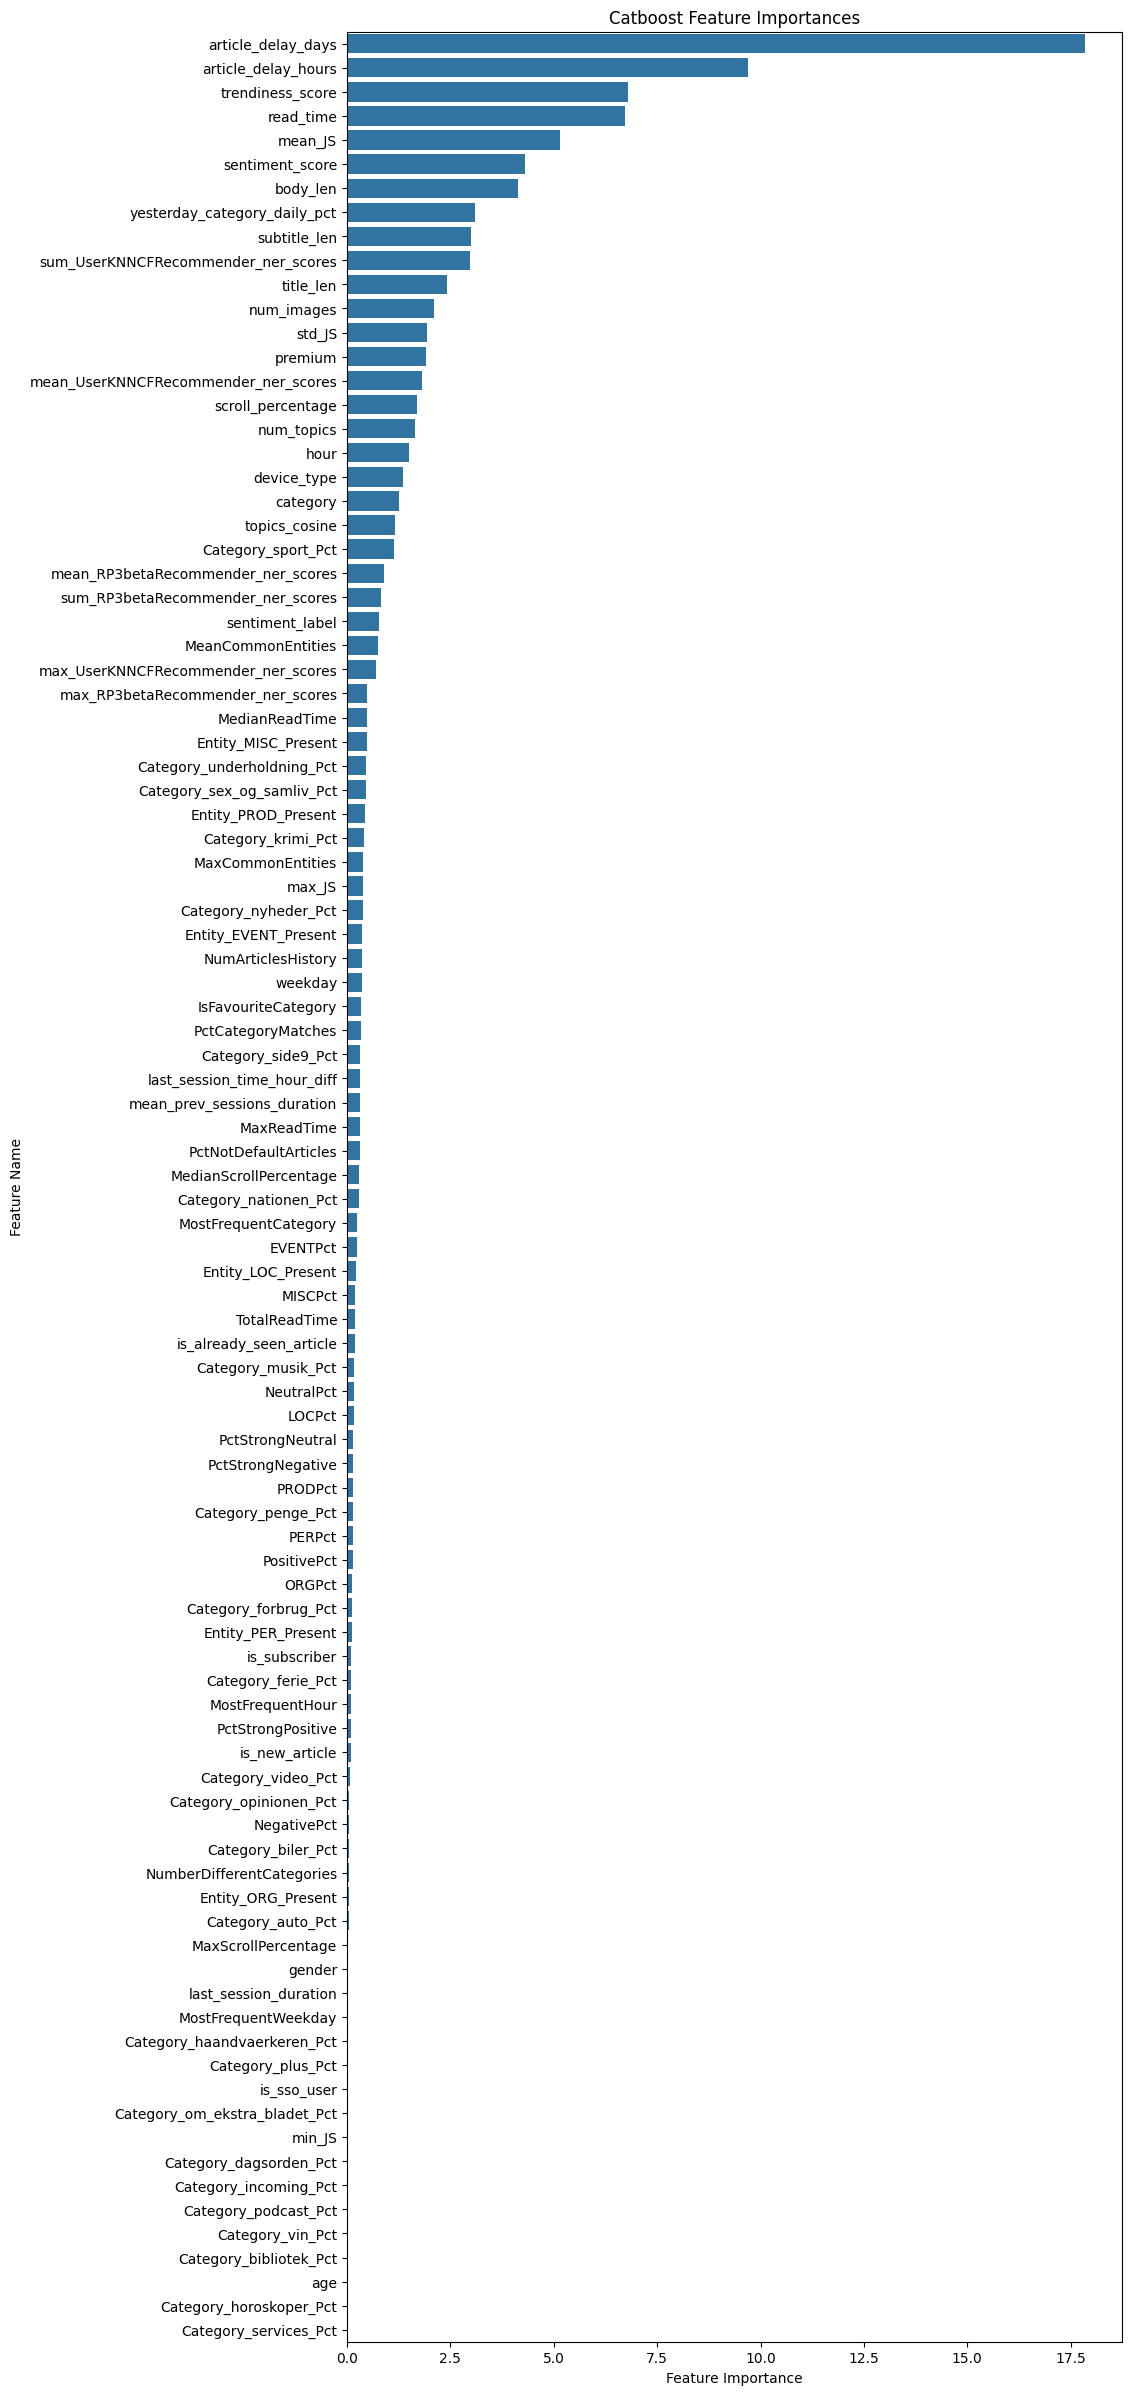

In [18]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 30))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')